# Data Description

This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allow viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. There is also a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data which has been anonymised.

# Context

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. 

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

# Data Science Problem Statement(s)

Through this dataset, I will use various machine learning methods for the following problems -  

1) Segmentation - How can customers be clustered based on their purchase habits?   
2) Customer Lifetime Value - How much will a customer bring in future revenue?  
3) Churn - Which customers are likely to remain or not remain with Olist?  
4) Recommendations - How can we increase user basket size by engaging users more with a recommendation system?  
5) Customer reviews - Can we predict customer review scores based on the various features?

The data is divided into multiple datasets for better organization. As such I will be working with different sub sets across the various project steps - depending on the objective. Please refer to the following data schema for clarity:
<img src="https://i.imgur.com/HRhd2Y0.png" />


# Business Objective
The scope of this notebook is a binary classification problem, ie - for a given purchase order I will aim to predict if it will get a positive or negative review from the customer.

## Contents:
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Review Visualization](#Data-Visualization)
- [Feature-Engineering](#Feature-Engineering)
- [Model Prep](#Model-Prep)
- [Category Level Analysis](#Category-level-analysis)
- [Geospatial Analysis](#Geospatial-Analysis)
- [Next Steps](#Next-Steps)

# Data Import and Cleaning

In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from tqdm import tqdm
import shutil
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import random
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.metrics import log_loss,accuracy_score, confusion_matrix, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sahajchawla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /Users/sahajchawla/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [2]:
# loading the data tables
customer_data = pd.read_csv('../datasets/olist/olist_customers_dataset.csv')
geolocation_data = pd.read_csv('../datasets/olist/olist_geolocation_dataset.csv')
order_items_dataset = pd.read_csv('../datasets/olist/olist_order_items_dataset.csv')
order_payments_dataset = pd.read_csv('../datasets/olist/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('../datasets/olist/olist_order_reviews_dataset.csv')
order_dataset = pd.read_csv('../datasets/olist/olist_orders_dataset.csv')
order_products_dataset = pd.read_csv('../datasets/olist/olist_products_dataset.csv')
order_sellers_dataset = pd.read_csv('../datasets/olist/olist_sellers_dataset.csv')
product_translation_dataset = pd.read_csv('../datasets/olist/product_category_name_translation.csv')

From previous EDA, we know thatthe review data has review score for each 100k data points but less than 50% of the orders have review comments for them. Additionally, we want to predict customer review based on the order fullfillment rather than classifying their reviews as positive or negative based on the review comments posted by them.

According to our objective here i.e to predict the customer satisfaction based on the order fullfillment rather than classifying their reviews as negative or positive, the review comments given by customers should be removed from the data to avoid bias in the model.

In [3]:
# removing unuseful data from review data set
order_reviews_dataset = order_reviews_dataset[['order_id','review_score', 'review_comment_message']]
order_reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   order_id                100000 non-null  object
 1   review_score            100000 non-null  int64 
 2   review_comment_message  41753 non-null   object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


Now, the review data contains only order and their respective review score. so, let's merge other data tables with the review table to get the whole data set using the key given in data schema.

In [4]:
# Merging order data with review data to get a review score on each order
order_review_data = order_reviews_dataset.merge(order_dataset,on='order_id')
order_review_data.head()

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00
1,a548910a1c6147796b98fdf73dbeba33,5,NaN,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,5986b333ca0d44534a156a52a8e33a83,delivered,2018-02-10 10:59:03,2018-02-10 15:48:21,2018-02-15 19:36:14,2018-02-28 16:33:35,2018-03-09 00:00:00


As seen above the product dataset containd the product categories in portugese language. so, let's translate the product categories to english for better understanding.

In [5]:
# changing product name to english in the ordered product dataset
order_products_dataset_english = pd.merge(order_products_dataset,product_translation_dataset,on='product_category_name'
                                          ,how='left')
order_products_dataset_english = order_products_dataset_english.drop(labels='product_category_name',axis=1)
order_products_dataset_english.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


The above data set contains detailed description of each product item available for sale on website. So, let's merge this data with **order_items_dataset** which contains order details of each product item sold to get the product description of each item sold in the same data.

The dataset now contains the detailed description of each product ordered online such as price, dimensions, seller, number of photos available to customer, and product weight etc.

In [6]:
# merging item description to the products ordered data using product_id
order_product_item_dataset = pd.merge(order_items_dataset,order_products_dataset_english,on='product_id')
order_product_item_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff


In [7]:
# merging detailed product data with the order review data
ordered_product_reviews = pd.merge(order_product_item_dataset,order_review_data,on='order_id')
ordered_product_reviews_payments = pd.merge(ordered_product_reviews,order_payments_dataset,on='order_id')
ordered_product_reviews_payments.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,58.0,598.0,4.0,...,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1,credit_card,2,72.19
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,58.0,598.0,4.0,...,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,1,boleto,1,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,58.0,598.0,4.0,...,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00,1,credit_card,2,83.23
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,58.0,598.0,4.0,...,delivered,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25 00:00:00,1,credit_card,3,75.07
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,58.0,598.0,4.0,...,delivered,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01 00:00:00,1,credit_card,4,72.19


### Final data

Now, we have our final data set for each order_id for we have products info, sellers info, items info, customer info, payment info and review score given by the customer.
Let us dive deep into our data set and see what the data tells. let us start with simple statistics on the data.

In [8]:
# merging detailed product data with the order review data
df_final = pd.merge(ordered_product_reviews_payments,customer_data,on='customer_id')
# df_final.to_csv('olist_final.csv',index=False)
df_final.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,...,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,58.0,598.0,4.0,...,2017-09-20 23:43:48,2017-09-29 00:00:00,1,credit_card,2,72.19,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,58.0,598.0,4.0,...,2017-07-13 20:39:29,2017-07-26 00:00:00,1,boleto,1,73.86,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,58.0,598.0,4.0,...,2018-06-04 18:34:26,2018-06-07 00:00:00,1,credit_card,2,83.23,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,58.0,598.0,4.0,...,2017-08-09 21:26:33,2017-08-25 00:00:00,1,credit_card,3,75.07,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,58.0,598.0,4.0,...,2017-08-24 20:04:21,2017-09-01 00:00:00,1,credit_card,4,72.19,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG


In [9]:
#info on the data set
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118315 non-null  object 
 1   order_item_id                  118315 non-null  int64  
 2   product_id                     118315 non-null  object 
 3   seller_id                      118315 non-null  object 
 4   shipping_limit_date            118315 non-null  object 
 5   price                          118315 non-null  float64
 6   freight_value                  118315 non-null  float64
 7   product_name_lenght            116606 non-null  float64
 8   product_description_lenght     116606 non-null  float64
 9   product_photos_qty             116606 non-null  float64
 10  product_weight_g               118295 non-null  float64
 11  product_length_cm              118295 non-null  float64
 12  product_height_cm             

In [10]:
# checking the count of null values per column
df_final.isnull().sum()

order_id                             0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_name_lenght               1709
product_description_lenght        1709
product_photos_qty                1709
product_weight_g                    20
product_length_cm                   20
product_height_cm                   20
product_width_cm                    20
product_category_name_english     1734
review_score                         0
review_comment_message           67650
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   15
order_delivered_carrier_date      1254
order_delivered_customer_date     2588
order_estimated_delivery_date        0
payment_sequential                   0
payment_type             

The maximum missing values is seen in the order delivery date feature of the data set with around 2% of the total data. For the numerical features with null values we will use median impute technique( to avoid outliers) to handle missing value of these columns. For the date column order delivery date and order approve date we will fill the missing value from the corresponfiing estimated delivery date column and order purchase time column. The customer generally does not pay attention to the order_delivered_carrier_date of their order. so, we will drop this column. Also, the categorical product category feature have null values less than 1% of total data so, we will drop those rows having null values.

In [11]:
# Handling missing values
df_final['product_name_lenght'].fillna(df_final['product_name_lenght'].median(),inplace=True)
df_final['product_description_lenght'].fillna(df_final['product_description_lenght'].median(),inplace=True)
df_final['product_photos_qty'].fillna(df_final['product_photos_qty'].median(),inplace=True)
df_final['product_weight_g'].fillna(df_final['product_weight_g'].median(),inplace=True)
df_final['product_length_cm'].fillna(df_final['product_length_cm'].median(),inplace=True)
df_final['product_height_cm'].fillna(df_final['product_height_cm'].median(),inplace=True)
df_final['product_width_cm'].fillna(df_final['product_width_cm'].median(),inplace=True)

In [12]:
#Handling missing values
ids = (df_final[df_final['order_delivered_customer_date'].isnull() == True].index.values)
vals = df_final.iloc[ids]['order_estimated_delivery_date'].values
df_final.loc[ids,'order_delivered_customer_date'] = vals

ids = (df_final[df_final['order_approved_at'].isnull() == True].index.values)
df_final.loc[ids,'order_approved_at'] = df_final.iloc[ids]['order_purchase_timestamp'].values

#dropping order delivery carrier date
df_final.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [13]:
# filling nan value of review comments with no_review
df_final['review_comment_message'].fillna('no_review',inplace=True)

# dropping rows with product category name as null
df_final = df_final.dropna()

In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116581 entries, 0 to 118314
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       116581 non-null  object 
 1   order_item_id                  116581 non-null  int64  
 2   product_id                     116581 non-null  object 
 3   seller_id                      116581 non-null  object 
 4   shipping_limit_date            116581 non-null  object 
 5   price                          116581 non-null  float64
 6   freight_value                  116581 non-null  float64
 7   product_name_lenght            116581 non-null  float64
 8   product_description_lenght     116581 non-null  float64
 9   product_photos_qty             116581 non-null  float64
 10  product_weight_g               116581 non-null  float64
 11  product_length_cm              116581 non-null  float64
 12  product_height_cm             

In [15]:
# checking the review score 
df_final.review_score.value_counts()

5    65479
4    22017
1    15110
3     9842
2     4133
Name: review_score, dtype: int64

>According to our objective, we are going to solve this problem using binary classification technique. so, let us convert the review score into 0 and 1 labels and view the distribution. 

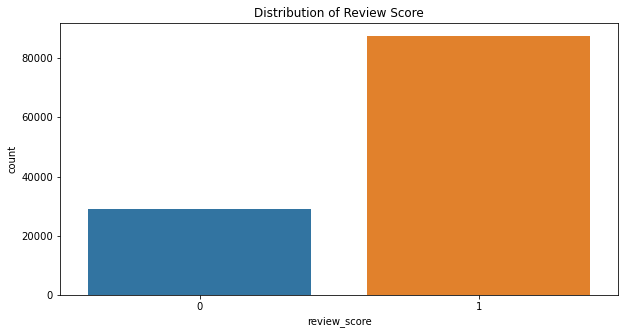

In [16]:
# converting reviews into 0 and 1 to make it binary classification problem
df_final['review_score'] = df_final['review_score'].apply(lambda x:1 if x>3 else 0)

#let us see the distribution now.
plt.figure(figsize=(10,5))
ax=sns.countplot(x="review_score", data=df_final)
plt.title('Distribution of Review Score')
plt.show()

We can see that more than 50% of the data points belong to the class label 1 i.e positive class and rest of them to the negative class suggesting that we have an imbalanced data set.

In [17]:
# statistics of numerical features in the data set
df_final.describe()

,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix
count,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000
mean,1.196953,120.751369,20.062550,48.766317,785.949331,2.204991,2115.548280,30.318534,16.645860,23.116872,0.750517,1.093369,2.949614,172.910258,35053.391556
std,0.701350,183.848421,15.845515,10.033728,652.614023,1.717417,3783.573942,16.222698,13.474688,11.758640,0.432716,0.727240,2.783798,267.622516,29817.864821
min,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,0.000000,1.000000,0.000000,0.000000,1003.000000
25%,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,1.000000,61.000000,11310.000000
50%,1.000000,74.900000,16.320000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1.000000,1.000000,2.000000,108.190000,24315.000000
75%,1.000000,134.900000,21.220000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,1.000000,1.000000,4.000000,189.720000,58600.000000
max,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,1.000000,29.000000,24.000000,13664.080000,99980.000000


###### Observation
We observe from above table that we have 12 useful numerical features except zip code, our target variable review score and order_item_id. let us observe the statistics of the price and freight value of an order. The maximum price of an order is 6735 while max freight went to around 410 Brazilian real. The average price of an order is around 120 Brazilian real and frieght value is around 20 Brazilian real. The order with minimum price of 0.85 Brazilian real have been made. Let us look at distribution of these features and see how they help in classifying the class labels and find other insights. 

# Data Visualization

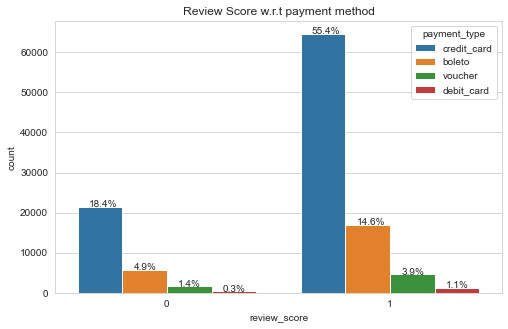

In [18]:
# count plot of payment type
# https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
ax = sns.countplot(x="review_score", hue="payment_type", data=df_final)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df_final)),(p.get_x()+0.05, p.get_height()+5))
ax.set_title('Review Score w.r.t payment method')
plt.show()

##### Observation
The plot above shows the distributio of the categorical variable payment type w.r.t the review score. From the plot we observe the around 55% of the positive review given by customers have used credit card for the payments. Similarly, for negative review around 18% of customers made payment using credit cared while in the second postion we have boleto -  digital currency provided by the eCommerce site for their regular and registered customers.

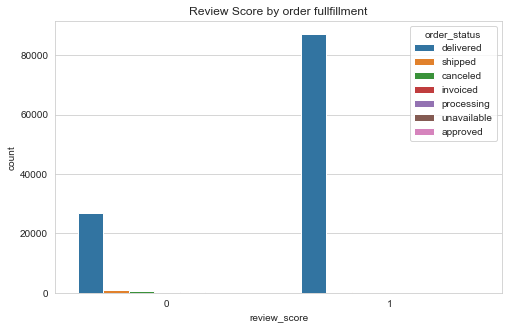

In [19]:
# count plot of order fullfillment
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
ax = sns.countplot(x="review_score", hue="order_status", data=df_final)
ax.set_title('Review Score by order fullfillment')
plt.show()

##### Observation
The plot above is a very simple plot which shows the distribution of review score given per order status of the order. From the plot we can observe that out of all the orders which got positive review 99% of them has been successfully delivered. 

# Feature Engineering
let us create some features and analyse them.
1. **Sellers Count**:- Number of sellers for each product as a feature.
2. **Products count**:- Number of products ordered in each order as a feature.
3. **Estimated Delivery Time(in number of days)**:- Gets the days between order approval and estimated delivery date. A customer might be unsatisfied if he is told that the estimated time is big.
4. **Actual Delivery Time**:- Gets the days between order approval and delivered customer date. A customer might be more satisfied if he gets the product faster.
5. **Difference in delivery days**:- The difference between the actual and estimated date. If negative was delivered early, if positive was delivered late. A customer might be more satisfied if the order arrives sooner than expected, or unhappy if he receives after the deadline
6. **Is Late**:- Binary variable indicating if the order was delivered after the estimated date.
7. **Average Product Value**:- Cheaper products might have lower quality, leaving customers unhappy.
8. **Total Order Value**:- If a customer expends more, he might expect a better order fulfilment.
9. **Order Freight Ratio**:- If a customer pays more for freight, he might expect a better service.
10. **Purchase Day of Week**:- Day of week on which purchase was made.
11. **is_reviewed**:- If the review comment is given or not.

In [20]:
# Finding number of sellers for each product as a feature
product_id = order_product_item_dataset.groupby('product_id').count()['seller_id'].index
seller_count = order_product_item_dataset.groupby('product_id').count()['seller_id'].values
product_seller_count = pd.DataFrame({'product_id':product_id,'sellers_count':seller_count})
product_seller_count.head()

,product_id,sellers_count
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,2
4,000d9be29b5207b54e86aa1b1ac54872,1


In [21]:
# Finding number of products ordered in each order as a feature
order_id = order_product_item_dataset.groupby('order_id').count()['product_id'].index
pd_count = order_product_item_dataset.groupby('order_id').count()['product_id'].values
order_items_count = pd.DataFrame({'order_id':order_id,'products_count':pd_count})
order_items_count.head()

,order_id,products_count
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1


In [22]:
# Adding the seller count and products count feature to the final data set
df_final = pd.merge(df_final,product_seller_count,on='product_id')
df_final = pd.merge(df_final,order_items_count,on='order_id')

# converting date to datetime and extracting dates from the datetime columns in the data set
datetime_cols = ['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']
for col in datetime_cols:
    df_final[col] = pd.to_datetime(df_final[col]).dt.date

In [23]:
# https://www.kaggle.com/andresionek/predicting-customer-satisfaction
# calculating estimated delivery time
df_final['estimated_delivery_time'] = (df_final['order_estimated_delivery_date'] - df_final['order_approved_at']).dt.days

# calculating actual delivery time
df_final['actual_delivery_time'] = (df_final['order_delivered_customer_date'] - df_final['order_approved_at']).dt.days

# calculating diff_in_delivery_time
df_final['diff_in_delivery_time'] = df_final['estimated_delivery_time'] - df_final['actual_delivery_time']

# finding if delivery was lare
df_final['on_time_delivery'] = df_final['order_delivered_customer_date'] < df_final['order_estimated_delivery_date']
df_final['on_time_delivery'] = df_final['on_time_delivery'].astype('int')

# calculating mean product value
df_final['avg_product_value'] = df_final['price']/df_final['products_count']

# finding total order cost
df_final['total_order_cost'] = df_final['price'] + df_final['freight_value']

# calculating order freight ratio
df_final['order_freight_ratio'] = df_final['freight_value']/df_final['price']

# finding the day of week on which order was made
df_final['purchase_dayofweek'] = pd.to_datetime(df_final['order_purchase_timestamp']).dt.dayofweek

# adding is_reviewed where 1 is if review comment is given otherwise 0.
df_final['is_reviewed'] = (df_final['review_comment_message'] != 'no_review').astype('int')

In [24]:
df_final.drop(columns=['order_id', 'order_item_id', 'product_id', 'seller_id','shipping_limit_date','customer_id',
                       'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'customer_state',
                       'order_estimated_delivery_date','customer_unique_id', 'customer_city','customer_zip_code_prefix'],
              axis=1,inplace=True)

In [25]:
# Final data set after feature creation and removing of irrelevant features
# df_final.to_csv('olist_final.csv',index=False)
df_final.head()

,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,...,products_count,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,avg_product_value,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
0,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,...,1,16,7,9,1,58.9,72.19,0.225637,2,1
1,55.9,17.96,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,...,1,27,14,13,1,55.9,73.86,0.321288,2,1
2,64.9,18.33,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,...,1,20,17,3,1,64.9,83.23,0.282435,4,1
3,58.9,16.17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,...,1,24,8,16,1,58.9,75.07,0.274533,1,0
4,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,...,1,22,14,8,1,58.9,72.19,0.225637,3,0


In [26]:
# describe the data set
df_final[['sellers_count', 'products_count','estimated_delivery_time', 'actual_delivery_time','diff_in_delivery_time', 
          'avg_product_value','total_order_cost', 'order_freight_ratio']].describe()

,sellers_count,products_count,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,avg_product_value,total_order_cost,order_freight_ratio
count,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000
mean,36.179455,1.393855,23.990007,12.192699,11.797308,110.351657,140.813919,0.321906
std,81.397623,1.112939,8.905054,9.649015,10.200133,181.484738,190.993525,0.350780
min,1.000000,1.000000,-6.000000,-7.000000,-188.000000,0.057143,6.080000,0.000000
25%,2.000000,1.000000,19.000000,6.000000,7.000000,29.950000,55.370000,0.134928
50%,7.000000,1.000000,23.000000,10.000000,12.000000,61.900000,92.030000,0.232254
75%,26.000000,1.000000,29.000000,15.000000,17.000000,122.900000,157.790000,0.393538
max,527.000000,21.000000,154.000000,208.000000,147.000000,6735.000000,6929.310000,26.235294


##### Observation
Let us observe the statistics of the features we created.
1. The sellers count for total products ordered in a order have minimum number of sellers as 1 while maximum sellers of 527.
2. The numer of products ordered in a single order have maximum value as 21 and minimum as 1.
3. The maximum estimated delivery time is 154 days with mean value of 23 days.
4. The maximum actual delivery time is 208 days and with average delivery time of 12 days.
5. Average total order cost 140 brazilian real with minimum value of 6 real.

<Figure size 432x288 with 0 Axes>

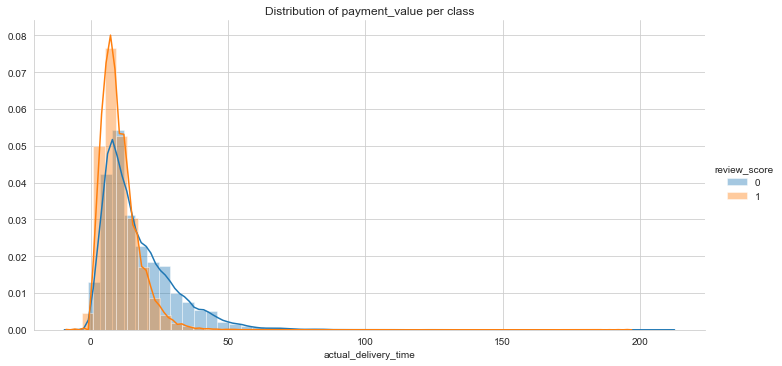

In [27]:
# distribution plot of actual delivery time
plt.figure()
sns.set_style("whitegrid")
ax = sns.FacetGrid(df_final, hue="review_score", height=5,aspect=2.0)
ax = ax.map(sns.distplot, "actual_delivery_time").add_legend();
plt.title('Distribution of payment_value per class')
plt.show()

##### Observation
For all the univariate distribution up until now, we have observed complete overlap for both classed while in the above plot we can see some difference in distributions for postive and negative classed. The negative class is more skewed to right than the positive class inferring that the increase in delivery time affects the review score.

<Figure size 432x288 with 0 Axes>

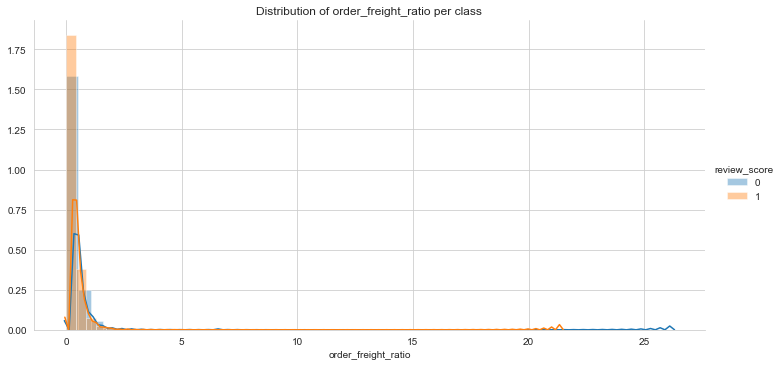

In [28]:
# distribution plot of payment value
plt.figure()
sns.set_style("whitegrid")
ax = sns.FacetGrid(df_final, hue="review_score", height=5,aspect=2.0)
ax = ax.map(sns.distplot, "order_freight_ratio").add_legend();
plt.title('Distribution of order_freight_ratio per class')
plt.show()

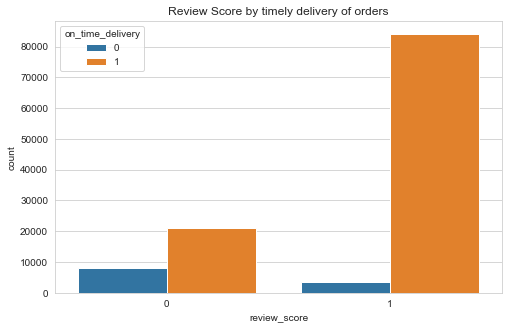

In [29]:
# distribution review by on time delivery
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
ax = sns.countplot(x="review_score", hue="on_time_delivery", data=df_final)
ax.set_title('Review Score by timely delivery of orders')
plt.show()

###### Observation
From plot titled `distribution of order freight ratio` we observe overlap for both the classes. So, we will go for bivariate/multivariate analysis for this features.
Also, from the plot titled `review score by order fullfillment` we observe that out of all the review classified as positive 90% of them were delivered on or before time to the customer.

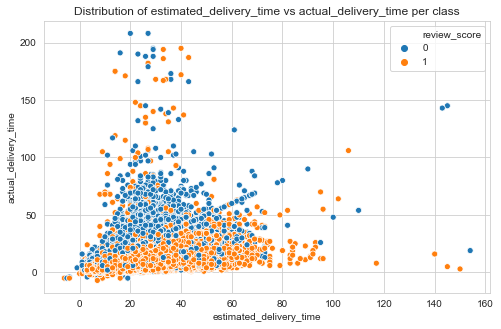

In [30]:
# Distribution of price vs freight_value per class
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
ax = sns.scatterplot(x='estimated_delivery_time',y='actual_delivery_time', data = df_final, hue="review_score")
plt.title('Distribution of estimated_delivery_time vs actual_delivery_time per class')
plt.show()

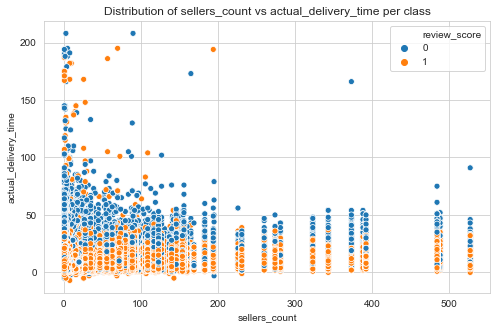

In [31]:
# Distribution of price vs freight_value per class
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
ax = sns.scatterplot(x='sellers_count',y='actual_delivery_time', data = df_final, hue="review_score")
plt.title('Distribution of sellers_count vs actual_delivery_time per class')
plt.show()

###### Observation
From the univariate analysis, we have seen that actual delivery time's distibution is partially overlapping for both the class lables and we cannot derive any certain rule to classify them based on the actual delivery time. So, we plotted the above scatter plots to see if we can derive any relation with more than one features. From the plots above we observe that we can separate the blue points from the orange points with a linear line with some errors. Thus, now we can say that we can derive some linear relation to classify them. let us verify our observation from below pair plot.

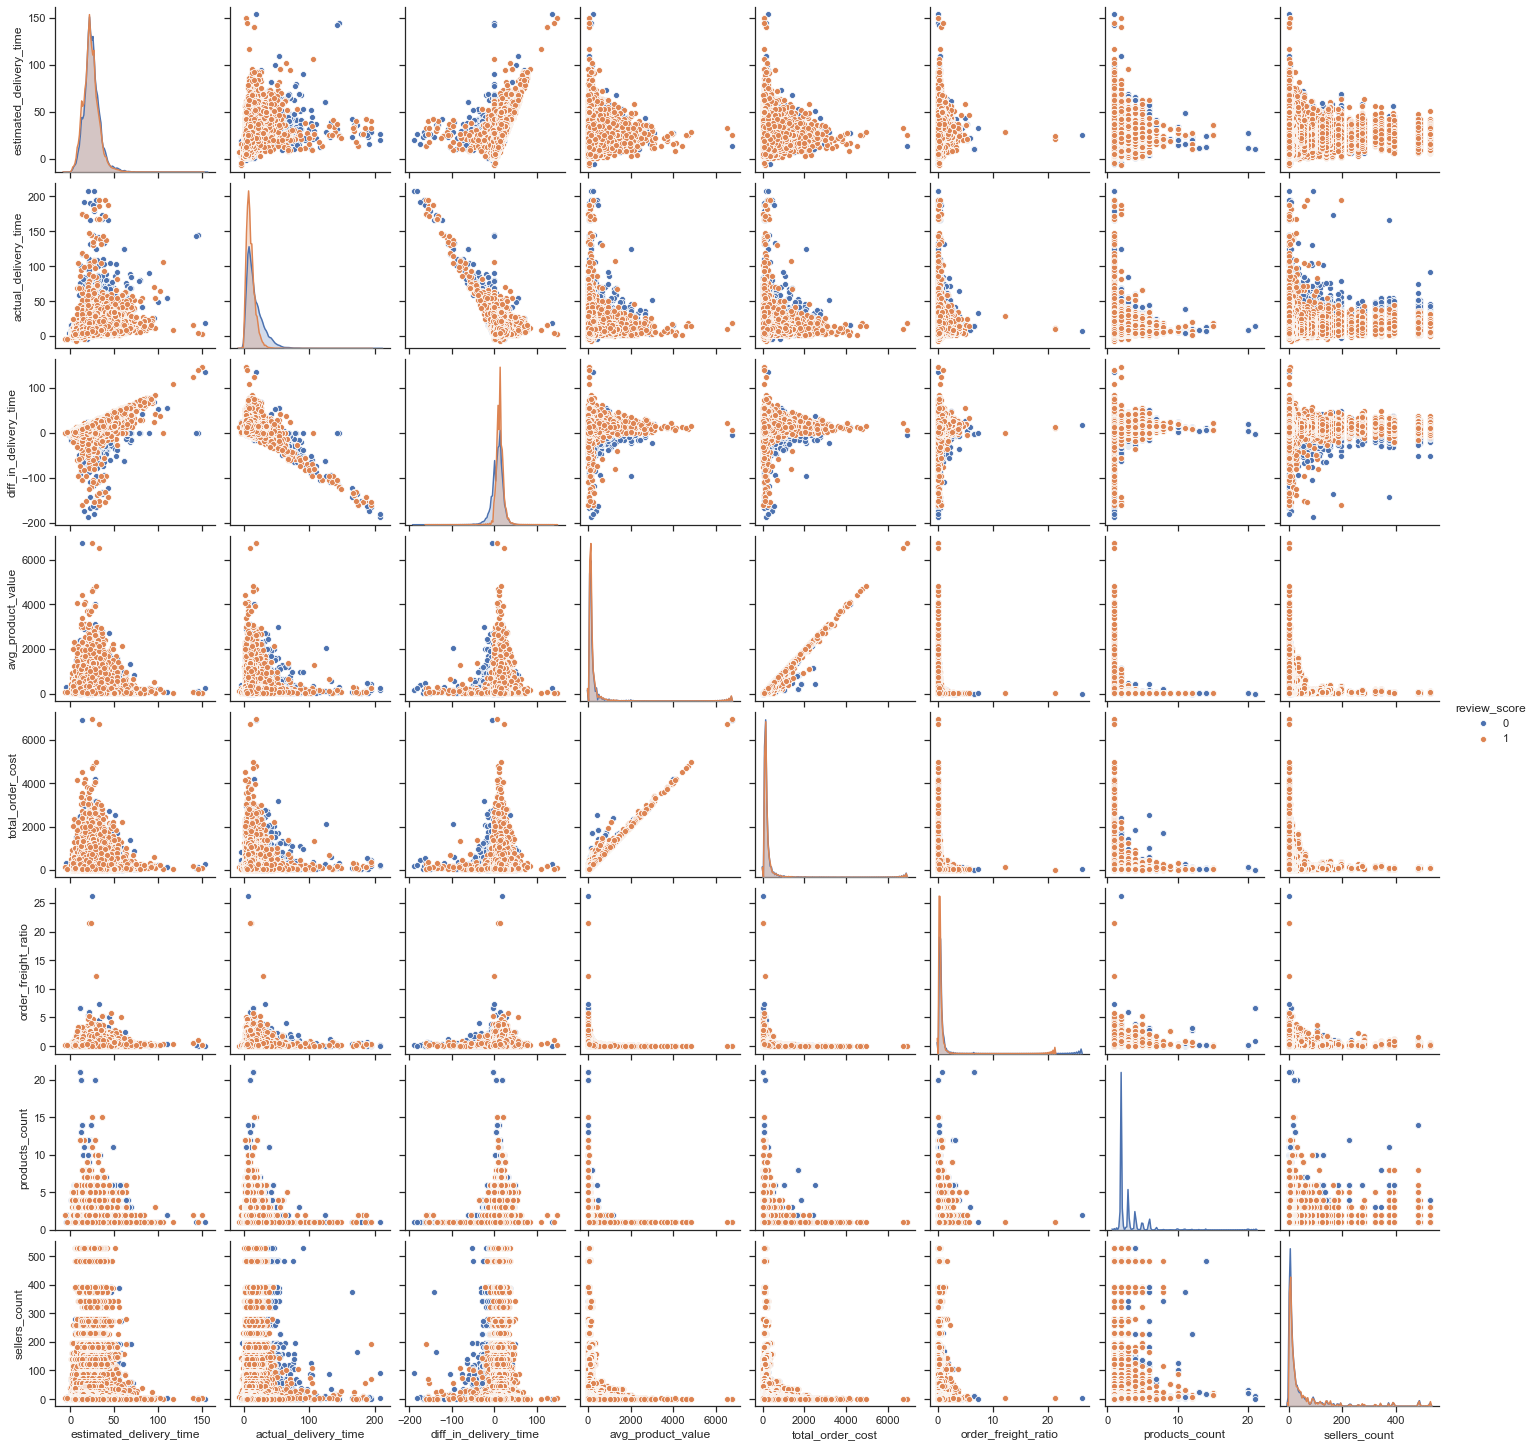

In [32]:
# pair plot
feat = ['estimated_delivery_time','actual_delivery_time', 'diff_in_delivery_time','avg_product_value', 
           'total_order_cost', 'order_freight_ratio','products_count','sellers_count','review_score']
sns.set(style="ticks", color_codes=True)
pp = sns.pairplot(df_final[feat],hue='review_score')
# pp.savefig("pairplot2.png")

###### Observation
The Pairplot above is the bivariate analysis of 8 newly engineered features like sellers count, product count, delivery time in days etc. From the above plot we observe that actual delivery time vs sellers count plot separates the positive and negative classed more visibly than others. We can say that the number of sellers available and the actual delivery time affects the review score either postively or negatively which we can see in details in the correlation analysis of the features.

## Observations on EDA and FE
Let us gather what we have observed and learned so far from the data.
1. The class label is not balanced.
2. It is impossible to differentiate the classes based on any single feature.
3. The numerical feature like price and freight value have skewed distribution suggesting the presence of high boundary values.
4. The freight_value vs product photo qty plot shows good result for classifying the class labels.
5. The most used payment method is credit card.
6. We also found that aroudn 45% of the consumers belong to single state and most shopped product category among them is bed,bath,table,health and beauty.
7. As observed in the analysis, 10 different features were  created referencing some features in the data like:- products ccount, sellers count, total order cost, actual delivery time etc. and the previous features like delivery date, product_id etc. is dropped.
8. we learnt that the feature actual delivery time provide partial differentiation between positive and negative class.
9. The scatter plots plotted in the first part of thge analysis do not show any significant results in classifying the positive and negative points while the scatter plots in the second analysis after feature engineering shows significant difference in the positive and negative class points as evident from plot `Distribution of sellers_count vs actual_delivery_time per class`.
10. The pair plot shows that with these features can classify the postive class from negative class with some non linear transformation. 
11. As evident from scatter plots and pair plots , it is clear that linear algorithms or KNN might not be good choice in classifying these points. But, atleast we learnt that with thes set of features we can classify them into two classes.

# Model Prep

In [33]:
# selecting features 
# numerical features
num_feat = ['price', 'freight_value', 'product_name_lenght','product_description_lenght', 'product_photos_qty',
           'product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm','sellers_count', 
           'products_count', 'payment_sequential','payment_installments', 'payment_value','on_time_delivery', 
           'estimated_delivery_time','actual_delivery_time', 'diff_in_delivery_time','avg_product_value', 'purchase_dayofweek',
           'total_order_cost', 'order_freight_ratio','is_reviewed']

# categorical features
cat_feat = ['review_comment_message','product_category_name_english','order_status', 'payment_type']

In [34]:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='median')
si.fit(df_final[num_feat])
df_final[num_feat] = si.transform(df_final[num_feat])

In [35]:
# checking values of categorical features    
print("order Status: ",df_final.order_status.value_counts())
print("----------------------------------------------------------------------------")
print("Payment type: ",df_final.payment_type.value_counts())

order Status:  delivered      114067
shipped          1225
canceled          553
invoiced          364
processing        362
unavailable         7
approved            3
Name: order_status, dtype: int64
----------------------------------------------------------------------------
Payment type:  credit_card    86012
boleto         22692
voucher         6211
debit_card      1666
Name: payment_type, dtype: int64


We see that the we have two types and 3 types of data in on_time_delivery and payment_type column in the data. so, we will go with label encoding for these data rather than one hot encoding. Let us look at the review comments feature.

In [36]:
df_final['review_comment_message'][:10]

0       Perfeito, produto entregue antes do combinado.
1    lannister como sempre, entregou certinho e den...
2                                carrinho muito bonito
3                                            no_review
4                                            no_review
5                                            no_review
6    Muito bom chegou bem antes do prazo, produto d...
7                                            no_review
8                                            no_review
9                         o carrinho veio com defeito.
Name: review_comment_message, dtype: object

In [37]:
# https://www.aclweb.org/anthology/W17-6615

def process_data(texts):
    
    processed_text = []
    
    portuguese_stopwords = stopwords.words('portuguese') # portugese language stopwords
    stemmer = RSLPStemmer() # portugese language stemmer
    
    links = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' # check for hyperlinks
    dates = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}' # check for dates
    currency = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+' # check for currency symbols
    
    for text in tqdm(texts):
        text = re.sub('[\n\r]', ' ', text) # remove new lines
        text = re.sub(links, ' URL ', text) # remove hyperlinks
        text = re.sub(dates, ' ', text) # remove dates
        text = re.sub(currency, ' dinheiro ', text) # remove currency symbols
        text = re.sub('[0-9]+', ' numero ', text) # remove digits
        text = re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', text) # replace no with negative
        text = re.sub('\W', ' ', text) # remove extra whitespaces
        text = re.sub('\s+', ' ', text) # remove extra spaces
        text = re.sub('[ \t]+$', '', text) # remove tabs etc.
        text = ' '.join(e for e in text.split() if e.lower() not in portuguese_stopwords) # remove stopwords
#         text = ' '.join(stemmer.stem(e.lower()) for e in text.split()) # stemming the words
        processed_text.append(text.lower().strip())
        
    return processed_text

We see that this is a text feature. So, let us process the texts before we go for encoding of the features. The function below will help us in processing the text and make it ready for use in the model.

In [38]:
processed_text = process_data(df_final['review_comment_message'])

100%|██████████| 116581/116581 [00:05<00:00, 22215.39it/s]


In [39]:
df_final['review_comment_message'] = processed_text
# nao_reveja = no_review in portugese
df_final['review_comment_message'] = df_final['review_comment_message'].replace({'no_review':'nao_reveja'}) 
# df_final.to_csv('olist_final.csv',index=False)

In [40]:
df_final['review_comment_message'].iloc[:10]

0            perfeito produto entregue antes combinado
1    lannister sempre entregou certinho dentro praz...
2                                      carrinho bonito
3                                           nao_reveja
4                                           nao_reveja
5                                           nao_reveja
6    bom chegou bem antes prazo produto ótima quali...
7                                           nao_reveja
8                                           nao_reveja
9                                carrinho veio defeito
Name: review_comment_message, dtype: object

In [41]:
# Encoding categorical variable
df_final['payment_type'] = df_final['payment_type'].replace({'credit_card':1,'boleto':2,'voucher':3,'debit_card':4})

In [42]:
# separating the target variable
y = df_final['review_score']
X = df_final.drop(labels='review_score',axis=1)

# train test 80:20 split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
print("Train data: ",X_train.shape,y_train.shape)
print("Train data: ",X_test.shape,y_test.shape)

Train data:  (93264, 27) (93264,)
Train data:  (23317, 27) (23317,)


#### 4 Encoding categorical features


In [43]:
# encoding feature order status
vect = CountVectorizer()
vect.fit(X_train['order_status'])
training_os = vect.transform(X_train['order_status'])
test_os = vect.transform(X_test['order_status'])


print("training product category: ",training_os.shape)
print("test product category: ",test_os.shape)

training product category:  (93264, 7)
test product category:  (23317, 7)


In [44]:
# encoding product category
cv = CountVectorizer()
cv.fit(X_train['product_category_name_english'])
training_pc = cv.transform(X_train['product_category_name_english'])
test_pc = cv.transform(X_test['product_category_name_english'])

print("training product category: ",training_pc.shape)
print("test product category: ",test_pc.shape)

training product category:  (93264, 71)
test product category:  (23317, 71)


In [45]:
# # Word2vec encoding
# # https://radimrehurek.com/gensim/models/word2vec.html
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

path = get_tmpfile("word2vec.model")

texts = [x.split(' ') for x in df_final['review_comment_message']]

w2vmodel = Word2Vec(texts, size=300, window=5, min_count=1, workers=4)
w2vmodel.save("word2vec.model")

w2vmodel = Word2Vec.load("word2vec.model")
w2vmodel.train(texts, total_examples=len(texts), epochs=10)

w2vmodel.wv['nao_reveja'].shape  # numpy vector of a word

(300,)

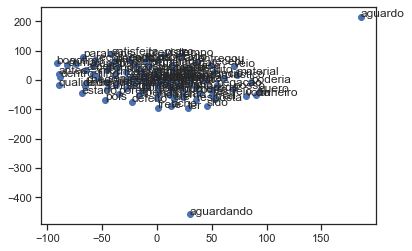

In [46]:
words =  list(w2vmodel.wv.vocab.keys())
vectors = [w2vmodel.wv[word] for word in words]

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

Y = tsne.fit_transform(vectors[:100])
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

In [47]:
# http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc#
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f.readlines()[1:]):
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], "float32")#np.array([float(0) if val=='0,0' else float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

embeddings = loadGloveModel('../assets/glove_s300.txt')

Loading Glove Model


100%|██████████| 929605/929605 [01:44<00:00, 8913.21it/s] 


Done. 929605  words loaded!


In [48]:
def tfidfWord2Vector(text,glove_words,tfidf_words,tf_values):
    # average Word2Vec
    # compute average word2vec for each review.
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(text): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = w2vmodel.wv[word] # embeddings[word] 
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = tf_values[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    tfidf_w2v_vectors = np.asarray(tfidf_w2v_vectors)
    
    return tfidf_w2v_vectors

In [49]:
# encoding review comment message using Tfidf weighted W2V
tfidf = TfidfVectorizer()
tfidf.fit(X_train['review_comment_message'])
# pickle.dump(tfidf,open('tfidf_review_comments.pkl','wb'))

# we are converting a dictionary with word as a key, and the idf as a value
tf_values = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names())
glove_words = list(w2vmodel.wv.vocab.keys()) # list(embeddings.keys())

tfidf_w2v_vectors_train = tfidfWord2Vector(X_train['review_comment_message'].values,glove_words,tfidf_words,tf_values)
tfidf_w2v_vectors_test = tfidfWord2Vector(X_test['review_comment_message'].values,glove_words,tfidf_words,tf_values)

100%|██████████| 23317/23317 [00:03<00:00, 6451.83it/s]


In [50]:
tfidf_w2v_vectors_train.shape

(93264, 300)

In [51]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab = list()
for x in df_final['review_comment_message']:
    vocab.extend(x.split())
vocab = set(vocab)
word_index = {word:i+1 for i,word in enumerate(vocab)}
# pickle.dump(word_index,open('word_index.pkl','wb'))
vocab_size = len(word_index)+1
# integer encode the documents
X_train_encoded_text = []
for x in X_train['review_comment_message']:
    X_train_encoded_text.append([word_index[w] for w in x.split()])
    
X_test_encoded_text = []
for y in X_test['review_comment_message']:
    X_test_encoded_text.append([word_index[w] for w in y.split()])
    

# pad documents to a max length of 122 words as 95 percentile is 122
max_length = 122
X_train_padded_text = pad_sequences(X_train_encoded_text, maxlen=max_length, padding='post')
X_test_padded_text = pad_sequences(X_test_encoded_text, maxlen=max_length, padding='post')


print(X_train_padded_text.shape,X_test_padded_text.shape)

(93264, 122) (23317, 122)


In [52]:
# creating embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word,i in word_index.items():
    embedding_vector = w2vmodel.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)
# pickle.dump(embedding_matrix,open('embedding_matrix.pkl','wb'))

(15060, 300)


#### 4.4 Encoding numerical features

In [53]:
# encoding numerical features
for i in num_feat:
    normalizer = Normalizer()
    normalizer.fit(X_train[i].values.reshape(1,-1))
#     pickle.dump(normalizer,open(i+'.pkl','wb'))
    X_train[i] = normalizer.transform(X_train[i].values.reshape(1,-1))[0]
    X_test[i] = normalizer.transform(X_test[i].values.reshape(1,-1))[0]

In [54]:
# dropping categorical features

X_train = X_train.drop(labels=['review_comment_message','product_category_name_english','order_status'],axis=1)
X_test = X_test.drop(labels=['review_comment_message','product_category_name_english','order_status'],axis=1)

print(X_train.shape,X_test.shape)

(93264, 24) (23317, 24)


In [55]:
# merging our encoded categorical features with rest of the data 
X_train_merge = hstack((X_train, training_pc, training_os)) #, tfidf_w2v_vectors_train)
X_test_merge = hstack((X_test, test_pc, test_os))# ,tfidf_w2v_vectors_test)

print("Train shape:",X_train_merge.shape)
print("Test shape:",X_test_merge.shape)

Train shape: (93264, 102)
Test shape: (23317, 102)


In [56]:
# merging our encoded categorical features with rest of the data 
X_train_other = hstack((X_train, training_pc, training_os))
X_test_other = hstack((X_test, test_pc, test_os))

print("Train shape:",X_train_other.shape)
print("Test shape:",X_test_other.shape)

Train shape: (93264, 102)
Test shape: (23317, 102)


# Model Selection

## Logistic Regression

In [57]:
def confusion_matrices_plot(y_real, y_pred, y_test,y_test_pred):
    # representing confusion matric in heatmap format
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    cmap=sns.light_palette("brown")
    C1 = confusion_matrix(y_real,y_pred)
    C2 = confusion_matrix(y_test,y_test_pred)
    
    fig,ax = plt.subplots(1, 2, figsize=(15,5))
    ax1 = sns.heatmap(C1, annot=True, cmap=cmap, fmt=".2f", ax = ax[0])
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('Original Class')
    ax1.set_title("Train Confusion matrix")

    ax2 = sns.heatmap(C2, annot=True, cmap=cmap, fmt=".2f", ax = ax[1])
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('Original Class')
    ax2.set_title("Test Confusion matrix")
    
    plt.show()

Alpha =  0.001 Train Score 0.8646697674418605 test Score 0.8642373427926475
Alpha =  0.01 Train Score 0.8626539393639645 test Score 0.8626413040789571
Alpha =  0.1 Train Score 0.857478868063212 test Score 0.8574858514834505
Alpha =  1 Train Score 0.857478868063212 test Score 0.8574858514834505
Alpha =  10 Train Score 0.857478868063212 test Score 0.8574858514834505
Alpha =  100 Train Score 0.857478868063212 test Score 0.8574858514834505
Alpha =  1000 Train Score 0.39013248058474187 test Score 0.3803429741489634


Text(0.5, 1.0, 'Alpha vs Score')

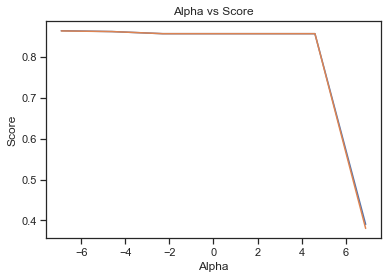

In [58]:
# Training Logistic regression model and chekcing f1 score metric
alpha = [0.001,0.01,0.1,1,10,100,1000]
train_scores = [] # store train scores
test_scores = [] # store test scores

for i in alpha:
    lr = SGDClassifier(loss='log', penalty='l2', alpha=i, n_jobs=-1, random_state=25)
    lr.fit(X_train_merge,y_train)
    train_sc = f1_score(y_train,lr.predict(X_train_merge))
    test_sc = f1_score(y_test,lr.predict(X_test_merge))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Alpha = ',i,'Train Score',train_sc,'test Score',test_sc)
    
# plotting the scores vs parameters
plt.plot(np.log(alpha),train_scores,label='Train Score')
plt.plot(np.log(alpha),test_scores,label='Test Score')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Alpha vs Score')

In [59]:
# Parameter tuning of Logistic regression using RandomisedSearch CV technique
sgd = SGDClassifier(loss='log', n_jobs=-1, random_state=25)
 
prams={ 'alpha': [0.001,0.01,0.1,1,10,100,1000] }

random_cfl1 = RandomizedSearchCV(sgd,param_distributions=prams,verbose=10,scoring='f1',n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(X_train_merge,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    7.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    8.1s finished


mean test scores [0.86466982 0.86304815 0.85747887 0.85747887 0.85747887 0.85747887
 0.76396345]
mean train scores [0.86466977 0.86307998 0.85747887 0.85747887 0.85747887 0.85747887
 0.76402117]


In [60]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'alpha': 0.001}
Best Score:  0.8646698153810277


In [61]:
# Fitting LogisticRegression mpdel on best parameters
sgd = SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=25)
sgd.fit(X_train_merge,y_train)
#pickle.dump(sgd,open('models/logistic.pkl','wb'))

y_train_pred = sgd.predict(X_train_merge)
y_test_pred = sgd.predict(X_test_merge)

# printing train and test scores 
print('Train f1 score: ',f1_score(y_train,y_train_pred))
print('Test f1 score: ',f1_score(y_test,y_test_pred))

Train f1 score:  0.8646697674418605
Test f1 score:  0.8642373427926475


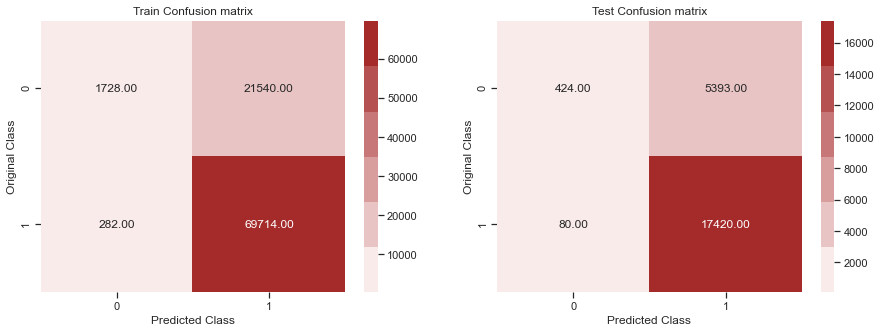

In [62]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred)

###### Observation
The first model trained is LogisticRegression and f1-score is used as the metric. We used randomisedsearch cross validation technique to tune the parametrs of the model. The best parameter we got is alpha=0.01 with f1-score of approx 0.91.The score looks quite good in one look so, to observe closely we plotted confusion matrix. Looking at the confusion matrix, we observe that TP values of model is very good while TN values are struggling with FNs. So, let us train some different models and observe the difference.  

# Linear SVM

Alpha =  0.001 Train Score 0.8646697674418605 test Score 0.8642373427926475
Alpha =  0.01 Train Score 0.8646697674418605 test Score 0.8642373427926475
Alpha =  0.1 Train Score 0.857478868063212 test Score 0.8574858514834505
Alpha =  1 Train Score 0.857478868063212 test Score 0.8574858514834505
Alpha =  10 Train Score 0.857478868063212 test Score 0.8574858514834505
Alpha =  100 Train Score 0.857478868063212 test Score 0.8574858514834505
Alpha =  1000 Train Score 0.39013248058474187 test Score 0.3803429741489634


Text(0.5, 1.0, 'Alpha vs Score')

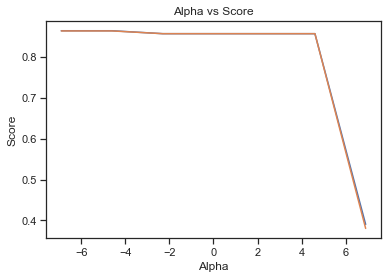

In [63]:
# Training Logistic regression model and chekcing f1 score metric
alpha = [0.001,0.01,0.1,1,10,100,1000]
train_scores = [] # store train scores
test_scores = [] # store test scores

for i in alpha:
    lr = SGDClassifier(loss='hinge', penalty='l2', alpha=i, n_jobs=-1, random_state=25)
    lr.fit(X_train_merge,y_train)
    train_sc = f1_score(y_train,lr.predict(X_train_merge))
    test_sc = f1_score(y_test,lr.predict(X_test_merge))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Alpha = ',i,'Train Score',train_sc,'test Score',test_sc)
    
# plotting the scores vs parameters
plt.plot(np.log(alpha),train_scores,label='Train Score')
plt.plot(np.log(alpha),test_scores,label='Test Score')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Alpha vs Score')

In [64]:
# Parameter tuning of Logistic regression using RandomisedSearch CV technique
sgd = SGDClassifier(loss='hinge', n_jobs=-1, random_state=25)
 
prams={ 'alpha': [0.001,0.01,0.1,1,10,100,1000] }

random_cfl1 = RandomizedSearchCV(sgd,param_distributions=prams,verbose=10,scoring='f1',n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(X_train_merge,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    4.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    5.0s finished


mean test scores [0.86466982 0.86466982 0.85747887 0.85747887 0.85747887 0.85747887
 0.76396345]
mean train scores [0.86466977 0.86466977 0.85747887 0.85747887 0.85747887 0.85747887
 0.76402117]


In [65]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'alpha': 0.001}
Best Score:  0.8646698153810277


In [66]:
# Fitting LogisticRegression mpdel on best parameters
sgd = SGDClassifier(loss='hinge',alpha=0.001, n_jobs=-1, random_state=25)
sgd.fit(X_train_merge,y_train)
#pickle.dump(sgd,open('models/svm.pkl','wb'))

y_train_pred = sgd.predict(X_train_merge)
y_test_pred = sgd.predict(X_test_merge)

# printing train and test scores 
print('Train f1 score: ',f1_score(y_train,y_train_pred))
print('Test f1 score: ',f1_score(y_test,y_test_pred))

Train f1 score:  0.8646697674418605
Test f1 score:  0.8642373427926475


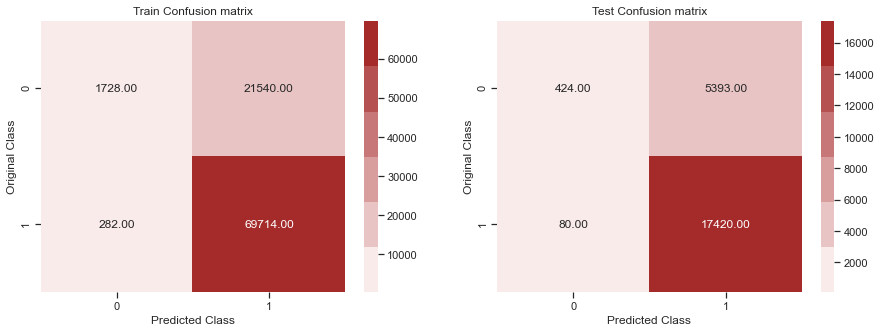

In [67]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred)

###### Observation
Here, we tried linear SVM classifer and used same approach as before to fine tune and train the model. Looking at the results we got, we observe that SVM is performing slightly better than LogisticRegression. From CM we observe that SVM is doing better for FPs than LR. let us look at some non-linear models.

# Decision Tree 

Depth =  3 Train Score 0.8775696079555805 test Score 0.7438081768246555
Depth =  10 Train Score 0.8905576924381492 test Score 0.7231664572448913
Depth =  50 Train Score 0.9995212404873343 test Score 0.6109920497753197
Depth =  100 Train Score 0.9995283895216727 test Score 0.5936894059580469
Depth =  250 Train Score 0.9995283895216727 test Score 0.5936894059580469
Depth =  500 Train Score 0.9995283895216727 test Score 0.5936894059580469


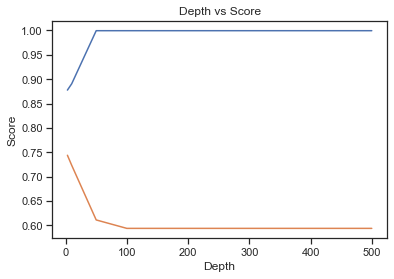

In [68]:
# Checking the variation of score with depth parameters of Decision Tree
depth = [3,10,50,100,250,500]
train_scores = []
test_scores = []
for i in depth:
    clf = DecisionTreeClassifier(max_depth=i,random_state=25)
    clf.fit(X_train_merge,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train_merge))
    test_sc = f1_score(y_test,clf.predict(X_test_merge))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Depth = ',i,'Train Score',train_sc,'test Score',test_sc)

# plotting the score vs depth
plt.plot(depth,train_scores,label='Train Score')
plt.plot(depth,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs Score')
plt.show()

In [69]:
# Parameter tuning of DecisionTreeClassifier using RandomisedSearch CV technique
# https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
dt = DecisionTreeClassifier(random_state=25)

params = { "max_depth": sp_randint(3,500), "min_samples_split": sp_randint(50,200), "min_samples_leaf": sp_randint(2,50)}

random_cfl1 = RandomizedSearchCV(dt, param_distributions=params,verbose=10,scoring='f1',n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(X_train_merge,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished


mean test scores [0.88393387 0.88352631 0.87943475 0.88388264 0.87915424 0.87887313
 0.86796572 0.88224709 0.8823768  0.88280447]
mean train scores [0.89128946 0.89146017 0.89579507 0.89112151 0.89623557 0.89643181
 0.90730151 0.89383213 0.89257402 0.89248117]


In [70]:
# printing best parameters and scores
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'max_depth': 135, 'min_samples_leaf': 28, 'min_samples_split': 193}
Best Score:  0.8839338682358557


In [71]:
# Fitting the model on best parameters
dt = DecisionTreeClassifier(max_depth = 320, min_samples_leaf = 25, min_samples_split = 186,random_state=25)
dt.fit(X_train_merge,y_train)
#pickle.dump(dt,open('models/decision_tree.pkl','wb'))

y_train_pred = dt.predict(X_train_merge)
y_test_pred = dt.predict(X_test_merge)

# printing train test score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.8925252714464432
Test f1 score 0.8038736643805373


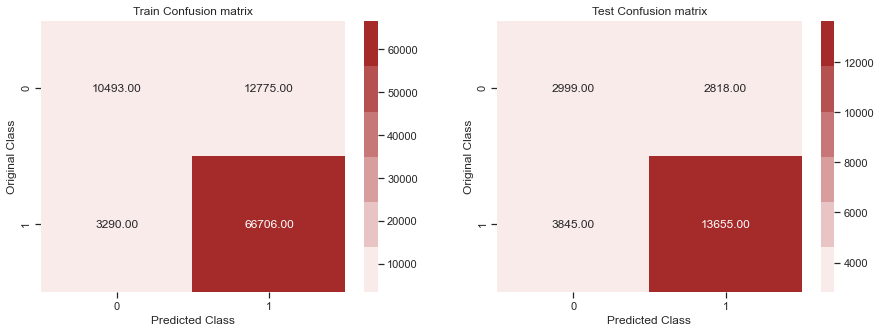

In [72]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred)

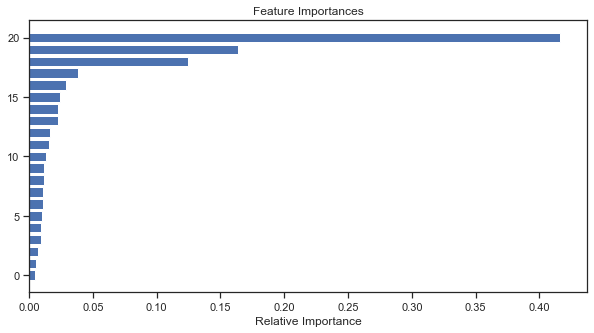

In [73]:
# checking some top features 
features = list(X_train.columns.values) #+ #cv.get_feature_names() + vect.get_feature_names() + tf.get_feature_names()# features list 
importances = dt.feature_importances_ # importance extracted from the model
indices = np.argsort(importances)[-21:] # top 20 features by importance value

# plotting top 20 features
plt.figure(figsize=(10,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###### Observation
After not getting promising results with linear models, we go with non linear models i.e tree and used DecsionTree Classifier as classification model. Firstly we trained the model for various values of depth of the tree to get the range of the parameters while fine uning the parameters during randomised serach cross validation. Keeping the results in last step as base line, the score obtained by this model during training is 0.88 which is better than previous model. 

Also, looking at the confusion matrices we see that we made some improvement in FalsePositives but while lost some in FalseNegatives suggesting that model is obviously learning differently than linear models. So, keeping these results in mind let us try ensemble techniques to further verify our hypothesis and try to achieve improved results.

We have also plotted feature importance map to look at some of the top features.

## Random Forest

Estimators =  1 Train Score 0.856038342687772 test Score 0.85635208935676
Estimators =  2 Train Score 0.8710642129055411 test Score 0.8782979160250487
Estimators =  5 Train Score 0.877917585945994 test Score 0.8750582750582749
Estimators =  10 Train Score 0.8792787950913024 test Score 0.8745046235138704
Estimators =  50 Train Score 0.8792044941246827 test Score 0.8757946968522252
Estimators =  100 Train Score 0.8792082752624378 test Score 0.8749449923636459
Estimators =  250 Train Score 0.8793549875663342 test Score 0.8746633519784545
Estimators =  500 Train Score 0.8793578746265595 test Score 0.8744819726481557


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

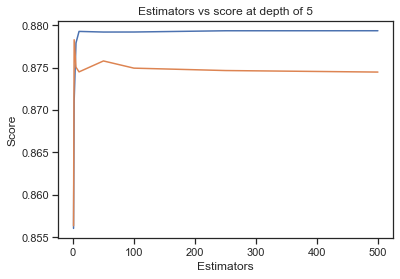

In [74]:
# Variation of score with estimators used in Random forest with other parameters set to constant value
estimators = [1,2,5,10,50,100,250,500]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train_merge,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train_merge))
    test_sc = f1_score(y_test,clf.predict(X_test_merge))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [75]:
# Parameter tuning of Random forest classifier using Randomised search CV
param_dist = {"n_estimators":sp_randint(1,500),
              "max_depth": sp_randint(3,20),
              "min_samples_split": sp_randint(50,200),
              "min_samples_leaf": sp_randint(2,50)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

random_cfl1 = RandomizedSearchCV(clf,param_distributions=param_dist,scoring='f1',verbose=10,n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(X_train_merge,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 32.2min finished


mean test scores [0.87964504 0.88684142 0.88111477 0.879435   0.87945107 0.88412941
 0.87963998 0.88666923 0.87953594 0.88553461]
mean train scores [0.87994435 0.89162763 0.88219849 0.8796336  0.87960699 0.88669325
 0.88007401 0.89233969 0.87986721 0.88999543]


In [76]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 182, 'n_estimators': 346}
Best Score:  0.8868414175299254


In [77]:
# Fitting the model on best parameters
rf = RandomForestClassifier(max_depth = 19, min_samples_leaf = 40, min_samples_split = 166, n_estimators = 131,random_state=25,
                           n_jobs=-1)
rf.fit(X_train_merge,y_train)
#pickle.dump(rf,open('models/random_forest.pkl','wb'))

y_train_pred = rf.predict(X_train_merge)
y_test_pred = rf.predict(X_test_merge)

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.890540363731519
Test f1 score 0.8750803514034712


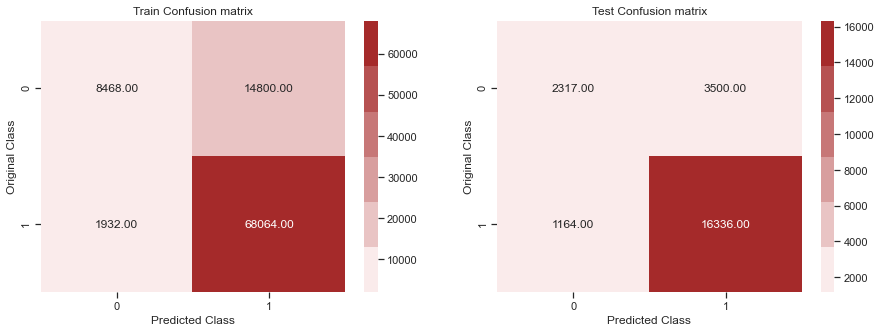

In [78]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred)

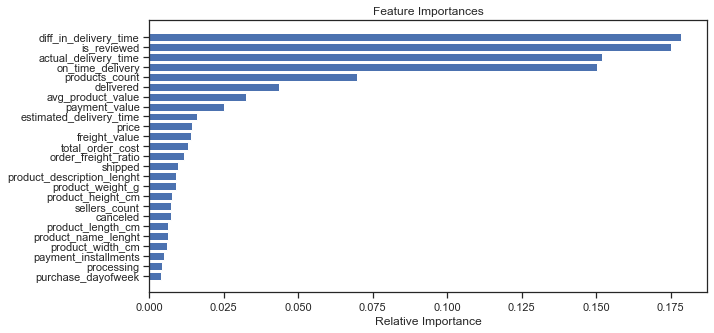

In [79]:
# plotting top 25 features
features = list(X_train.columns.values) + cv.get_feature_names() + vect.get_feature_names() # features list 
importances = rf.feature_importances_ # importance generated by model
indices = np.argsort(importances)[-25:]

plt.figure(figsize=(10,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###### Observation
From the previous models we observed that we were getting good results but the improvement was not that significant. So, we thought of going with ensemble models and the first one we will try is RandomForest.Let us see how this model do. We followed the same method for fine tuning and training the model as used in decision tree with some additional parameters like number of estimators etc. 

Now, looking at results of the model trained at best tuned parameters, we observe that model is performing somewaht similar to decision tree with almost same f1-score. Comparing the feature importance graph from previous one we observe that while the top 20 features are same but the order changed suggesting that these features are playing important role in teaching the model.

# LightGBM

Estimators =  1 Train Score 0.857478868063212 test Score 0.8574858514834505
Estimators =  3 Train Score 0.857478868063212 test Score 0.8574858514834505
Estimators =  5 Train Score 0.8740722150767011 test Score 0.8747164103856818
Estimators =  10 Train Score 0.8844695633207382 test Score 0.8697924916838271
Estimators =  50 Train Score 0.8924440760004814 test Score 0.7714993961736477
Estimators =  100 Train Score 0.8968151675225889 test Score 0.7715855323743291
Estimators =  250 Train Score 0.9056979314858972 test Score 0.7804938809827796
Estimators =  500 Train Score 0.9167486004374259 test Score 0.7871082381054502
Estimators =  1000 Train Score 0.9334625192601413 test Score 0.7982997066395259


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

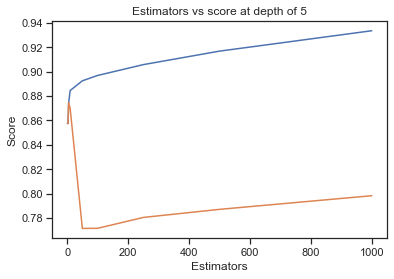

In [80]:
# Variation of score with estimators used in LGBM with other parameters set to default value
estimators = [1,3,5,10,50,100,250,500,1000]
train_scores = []
test_scores = []
for i in estimators:
    clf = LGBMClassifier(n_estimators=i, n_jobs=-1,random_state=25)
    clf.fit(X_train_merge,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train_merge))
    test_sc = f1_score(y_test,clf.predict(X_test_merge))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [81]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# Prameter tuning of the LGBM parameters using RandonSearch CV
x_cfl=LGBMClassifier(random_state=25,n_jobs=-1)

prams={
    'learning_rate':[0.001,0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[1,3,5,10,50,100,250,500,1000],
     'max_depth':[3,5,10,15,20,50],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,random_state=25,scoring='f1',
                               return_train_score=True)
random_cfl1.fit(X_train_merge,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.1min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
mean test scores [0.89460005 0.88155827 0.88563441 0.88994385 0.85747887 0.88834011
 0.88433485 0.85747887 0.8595956  0.85747887]
mean train scores [0.9085309  0.88282727 0.88806781 0.89612302 0.85747887 0.8938293
 0.88507433 0.85747887 0.8596383  0.85747887]


In [82]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'subsample': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1}
Best Score:  0.8946000508508742


In [83]:
# Fitting the model on best parameters
lgbm = LGBMClassifier(n_estimators=1000, max_depth=5,subsample=0.5,learning_rate=0.05,colsample_bytree=1,random_state=25,
                      n_jobs=-1)
lgbm.fit(X_train_merge,y_train)
#pickle.dump(lgbm,open('models/lgbm.pkl','wb'))

y_train_pred = lgbm.predict(X_train_merge)
y_test_pred = lgbm.predict(X_test_merge)

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9068488206554068
Test f1 score 0.7704912866731795


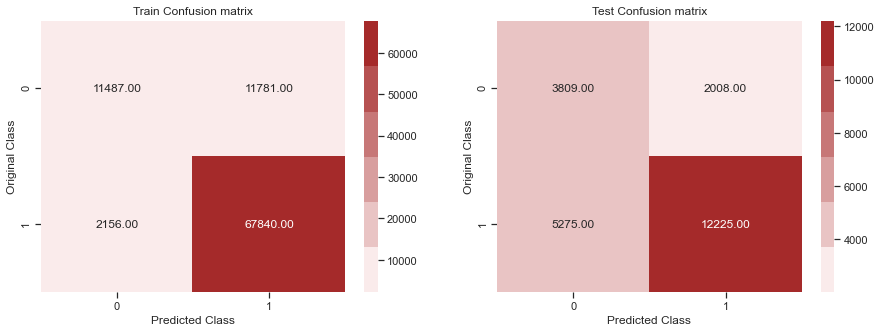

In [84]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred)

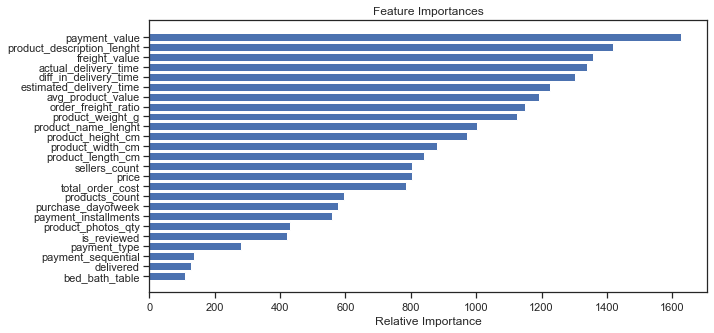

In [85]:
# ovserving top 25 features
importances = lgbm.feature_importances_
indices = np.argsort(importances)[-25:]

plt.figure(figsize=(10,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [86]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# Prameter tuning of the LGBM parameters using RandonSearch CV
x_cfl=XGBClassifier(random_state=25,n_jobs=-1)

prams={
    'learning_rate':[0.001,0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[1,3,5,10,50,100,250,500,1000],
     'max_depth':[3,5,10,15,20,50],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,random_state=25,scoring='f1',
                               return_train_score=True)
random_cfl1.fit(X_train_merge,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.7min finished


[10:53:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
mean test scores [0.88985346 0.88383008 0.88569216 0.89900115 0.85730048 0.89527937
 0.88412787 0.86552211 0.86887274 0.88289219]
mean train scores [0.90452657 0.8885635  0.88811063 0.95046461 0.85770956 0.91237904
 0.88522743 0.8812925  0.86972355 0.88651262]


In [87]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'subsample': 0.5, 'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.2, 'colsample_bytree': 0.3}
Best Score:  0.8990011452126581


In [88]:
# Fitting the model on best parameters
xgb = XGBClassifier(n_estimators=50, max_depth=15,subsample=0.5,learning_rate=0.2,colsample_bytree=0.3,random_state=25,
                      n_jobs=-1)
xgb.fit(X_train_merge,y_train)
#pickle.dump(xgb,open('models/xgb.pkl','wb'))

y_train_pred = xgb.predict(X_train_merge)
y_test_pred = xgb.predict(X_test_merge)

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

[10:53:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train f1 score 0.9450645060427684
Test f1 score 0.7960481150941706


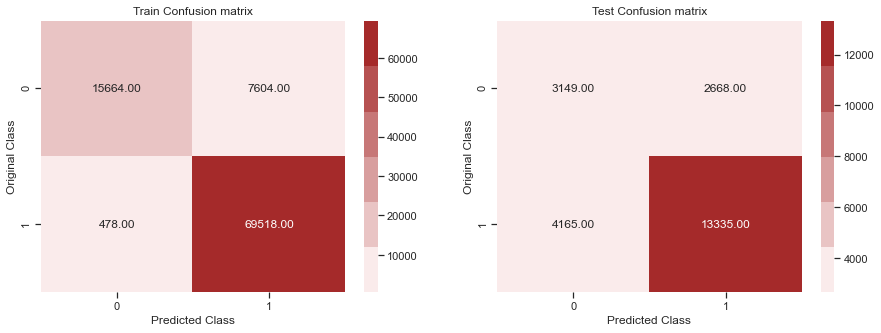

In [89]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred)

### AdaBoost

In [90]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# Prameter tuning of the LGBM parameters using RandonSearch CV
x_cfl=AdaBoostClassifier(random_state=25)

prams={
    'learning_rate':[0.001,0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[1,3,5,10,50,100,250,500,1000]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,random_state=25,scoring='f1',
                               return_train_score=True)
random_cfl1.fit(X_train_merge,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.0min finished


mean test scores [0.87362205 0.87362205 0.87375216 0.87355699 0.87362205 0.87362205
 0.87394706 0.88110143 0.87362205 0.88107586]
mean train scores [0.87362213 0.87362213 0.87375209 0.87371966 0.87362213 0.87362213
 0.87394723 0.88124822 0.87362213 0.88137481]


In [91]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'n_estimators': 100, 'learning_rate': 0.2}
Best Score:  0.8811014324053378


In [92]:
# Fitting the model on best parameters
ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.05, random_state=25)
ada.fit(X_train_merge,y_train)
#pickle.dump(ada,open('models/ada_boost.pkl','wb'))

y_train_pred = ada.predict(X_train_merge)
y_test_pred = ada.predict(X_test_merge)

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.8813627619196174
Test f1 score 0.8229747360929902


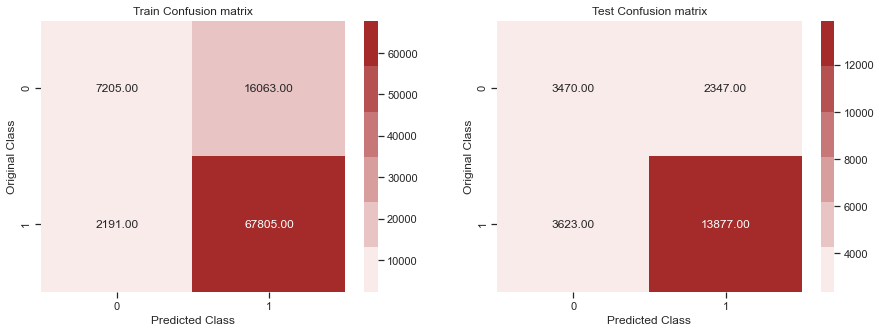

In [93]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred)

###### Observation
From the previous approches we found that ensembles are working well but we are yet to get beeter results. so, we decided to go with boosting techniques and decided to use Boosting Classifiers. We tried XGBoost, LightGBM and AdaBoost. Amongst them, the AdaBoost is found to be performing same as random forest but we got good resultswith XGBoost and LightGBM. The XgBoost achived best performance for training set among all the models with 0.94 f1 score while LGBM achieved best result on validation set with 0.93 f1-score. That means we got our best perfroming models but to furhter look for improvement we decided to go for stacking classifier.

###### Observation
In this approach, we kept our models tried so far as base estimators and trained another model on the probalistic values as well as predicted labels for each class predicted by the models. We will use sklearn Voting classifier model for this task with LR,DT,RF,and LGBM as base estimators and voting= soft/hard. The results obtained for both are similar but it does not surpass the results achieved by best stacking classifier.

|**MODELS**|**HYPERPARAMETERS**|**F1-SCORE**|
|------|--------|-------|
|LogisticRegression|alpha|0.9172|
|DecisionTree|max_depth|0.9262|
|Linear SVM|alpha|0.9174|
|Random Forest|max_depth,n_estimators,min_samples_leaf|0.9263|
|XGBoost(Boosting)|max_depth,n_estimators,learning_rate|0.9625|
|Stacking Classifier)|no_of_base_models, meta_classifier|0.96|
|Voting Classifer|estimators,voting,weights|0.9366|

### Summary On ML Models:-

Here, I will try to summarize what i tried and what worked and what did not. For training data we encoded categorical data with one hot encoding, standarized numerical features while for text features we tried **binary BOW, tfidf vectorizer, average w2v and tfidf averaged w2v** where w2v is trained on custom corpus using inbulit gensim models. We also tried previouly trained glove vectors on portugese words as shown above in the notebook. Various ML models including the models shown in the notebook are trained and evaluated on the these training data each. The best performing models are kept here in the notebook and among them the best is observed.

The training data with **standardized numerical features, one hot encoded categorical features and text features encoded using tfidf averaged w2v** gave best results for the models tried. Among them **XGBoost** achieved the best result with 0.96 f1-score.

To further improve the results, we tried **Stacking and Voting ensemble** technique with taking the base estimators from the models trained above in the notebook like LR, SVM, DT, RF, XGBoost and ADAClassifier etc. either all of them at time or some of them at time.

In voting classifier, we tried both the **hard and soft voting** technique as well as permutate the base estimators but we could not achieve the results better than the XGBoost.

For stacking, I also tried two-level custom stacking where I first trained a mix of linear and ensemble models on the predictions on the training data and then trained another layer mix of linear and ensemble models on the predictions made by this first layer and then finally a meta-classifier and observed the results.

The meta classifier is also varied for various types of models similar to base models from linear to ensemble models and the performance is observed. The best performing stacking model was found to be the models having LR, SVM, DT, RF, XGB as base estimators and **XGBoost** as meta classifier. All the other sequences of the models tried could not achieve the results given by this set of the stacking models. Finally, we achieved performance score of 0.9698 f1-score.

### 7. Observation on Model Trainning:-

Now, that the analysis, feature engineering and pre-processing is done it is time to train models on the data and observe results to selct the best model among them. So, let us have a look at what we learned:-
* The categorical features are encoded using one-hot encoding technique and numerical ones are standarised using sklearn normalizer modules to reduce the effect of outliers.
* The text feature used for trainig is encoded using tfidf averaged word2vec technique.
* The data is divided as train and test into 80:20 split for training and validation of the models.
* Various classification models like LogisticRegression, DecisionTree, RandomForest and LightGBM are trained and results were observed.
* The f1-score is used as performance metric to compare the performance of the models.
* The models are fine-tuned using randomised search cross validation hyper-parameters tuning technique and finaaly trained on the best parameters obtained.
* Confusion matrix is used to better understand the predictions of the models.
* Feature importance is also measured to look at some of the top features of the data and find the reasoning behind models predictions.
* The non-linear models are found to be performing well. Among them, XGBoost performed best with 0.96 f1-score.
* The performance results for each model can be observed in the above summary table.
* Other ensemble techniques like Stacking and Voting as well as NN models are used to further improve the results and reduce the errors.
* Voting performed better than some techniques but could not beat the performance of XGBoost.
* The Stacking classifier gave best results with train score of 0.974 and test score of 0.939 as provided in the above summary table.
* The NN models performed better then some linear models but couldn't beat the performance achieved by the stacking classifer suggesting that we need more data for them to achieve score better than this.
* The ensemble technique applied on the ouputs of the NN's models showed some improvement in the results but could not achieve better than our previous best.